# Reproducible Challenge Project
### Alexander Svensson & Love Sundin
2025-10-21

__(1)__ A well-defined problem


How benign the canser is.

__(2)__ Use data from an existing source, or generate data as part of a simulation experiment

[Länk Data](https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original)

In [2]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import numpy as np
import keras_tuner
import shap

In [3]:
# Read input data and convert
column_names = [
    "Sample code number",
    "Clump Thickness",
    "Uniformity of Cell Size",
    "Uniformity of Cell Shape",
    "Marginal Adhesion",
    "Single Epithelial Cell Size",
    "Bare Nuclei",
    "Bland Chromatin",
    "Normal Nucleoli",
    "Mitoses",
    "Class"
]
class_dict = {2: "Benign", 4: "Malignant"}
input_df = pd.read_csv("Data files/breast-cancer-wisconsin.data", header=None, names=column_names, na_values=["?"])
input_df["Class"] = input_df["Class"].replace(class_dict)

In [5]:
input_df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,Benign
1,1002945,5,4,4,5,7,10.0,3,2,1,Benign
2,1015425,3,1,1,1,2,2.0,3,1,1,Benign
3,1016277,6,8,8,1,3,4.0,3,7,1,Benign
4,1017023,4,1,1,3,2,1.0,3,1,1,Benign


In [6]:
input_df.describe()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [4]:
print(input_df.isna().sum())
print(f'Shape original: {input_df.shape}')
input_df = input_df.dropna()
print(f'Shape after drop: {input_df.shape}')

Sample code number              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64
Shape original: (699, 11)
Shape after drop: (683, 11)


In [5]:
# Split into training and test data
training_df, test_df = sklearn.model_selection.train_test_split(input_df, train_size=0.8, test_size=0.2, random_state=688712398)

Text(0.5, 1.0, 'Violin plots')

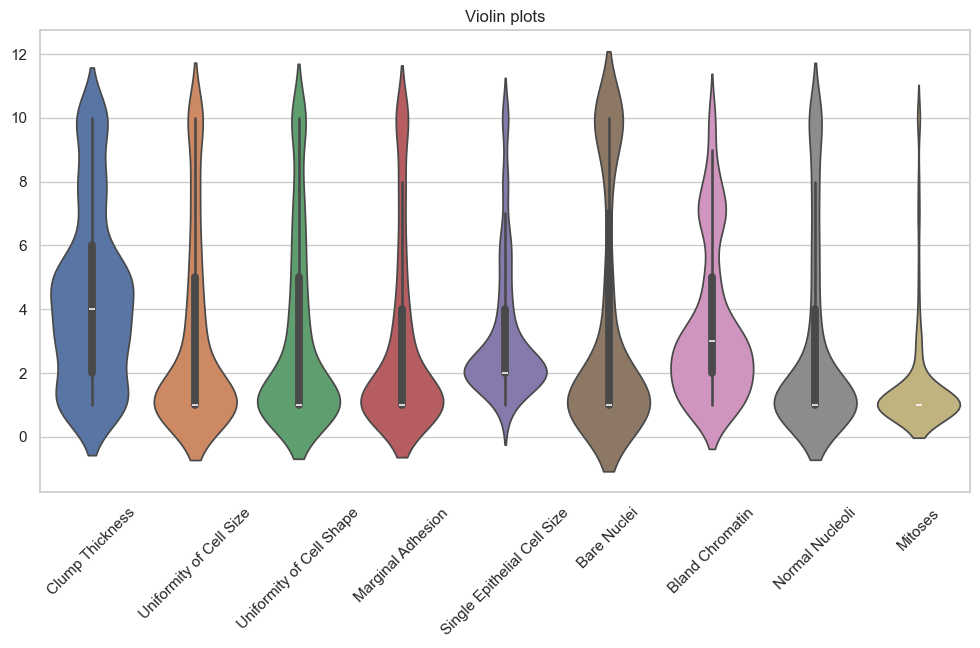

In [6]:
independent_variables = [
    "Clump Thickness",
    "Uniformity of Cell Size",
    "Uniformity of Cell Shape",
    "Marginal Adhesion",
    "Single Epithelial Cell Size",
    "Bare Nuclei",
    "Bland Chromatin",
    "Normal Nucleoli",
    "Mitoses"
]

sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
sns.violinplot(data=training_df[independent_variables], inner='box')
plt.xticks(rotation=45)
plt.title("Violin plots")

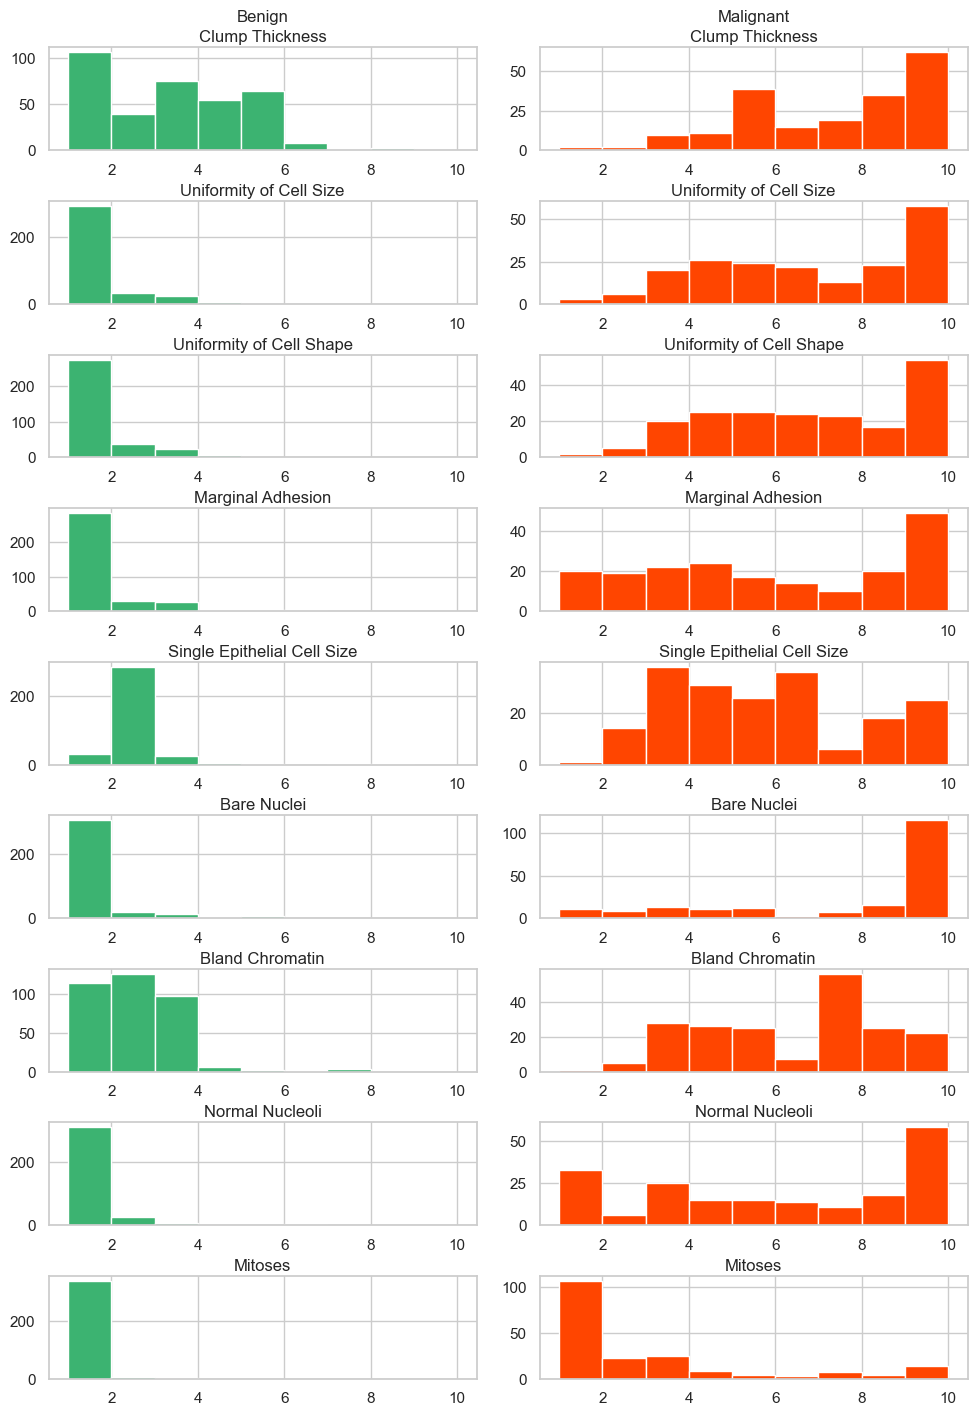

In [10]:
# Plot histograms for all independent variables

possible_classes = class_dict.values()

class_colors = ["mediumseagreen", "orangered"]

figure, axes = plt.subplots(9, 2)
figure.set_size_inches(10, 14)
figure.tight_layout()
bins = range(1, 11)
for class_index, tumor_class in enumerate(possible_classes):
    axis = axes[0, class_index]
    axis.set_title(tumor_class)
for variable_index, variable in enumerate(independent_variables):
    for class_index, tumor_class in enumerate(possible_classes):
        color = class_colors[class_index]
        axis = axes[variable_index][class_index]
        datapoints = training_df.query(f"Class == \"{tumor_class}\"")[variable]
        axis.hist(datapoints, color=color, bins=bins)
        axis.set_xlabel(variable)
        axis.xaxis.set_label_position('top') 

In [7]:
encoding_dict = {"Benign": 0, "Malignant": 1}

x_train = training_df[independent_variables]
y_train = training_df["Class"].replace(encoding_dict)
x_test = test_df[independent_variables]
y_test = test_df["Class"].replace(encoding_dict)

/tmp/ipykernel_5350/2490302067.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = training_df["Class"].replace(encoding_dict)
/tmp/ipykernel_5350/2490302067.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = test_df["Class"].replace(encoding_dict)


In [21]:
# Function for building a model with the given hyperparameters
def build_model(hyperparameters):
    simple_network = keras.Sequential()
    simple_network.add(keras.layers.Input(shape=(len(independent_variables),)))
    layers = hyperparameters.Int('layers', min_value=1, max_value=2, step=1)
    dropout_rate = hyperparameters.Float("dropout rate", min_value=0, max_value=0.5)
    # learning_rate = hyperparameters.Float("learning rate", min_value=1e-4, max_value=1, step=10, sampling="log")
    layer_nodes = []
    layer_nodes.append(hyperparameters.Int("layer 1 nodes", min_value=4, max_value=64, step=4))
    layer_nodes.append(hyperparameters.Int("layer 2 nodes", min_value=4, max_value=64, step=4))
    for layer in range(layers):
        # nodes
        simple_network.add(keras.layers.Dense(layer_nodes[layer], activation="relu"))
        if dropout_rate>0:
            simple_network.add(keras.layers.Dropout(dropout_rate))
    simple_network.add(keras.layers.Dense(1, activation="sigmoid"))
    simple_network.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss="binary_crossentropy", metrics=["accuracy", "precision", "recall"])
    return simple_network

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective='val_loss',
    executions_per_trial=2,
    directory='Hyperparameter tuning',
    overwrite=True,
    max_trials=50,
    num_initial_points=12,
    project_name='Tumor classification network',
    seed=1879214189
)
early_stopping=keras.callbacks.EarlyStopping("val_loss", patience=5, restore_best_weights=True)
tuner.search(x_train, y_train,
             batch_size=32,
             validation_split=0.2,
             epochs=200, 
             callbacks=[early_stopping])

Trial 50 Complete [00h 00m 19s]
val_loss: 0.03139762673527002

Best val_loss So Far: 0.027721446938812733
Total elapsed time: 00h 15m 02s


In [23]:
#optimized_model=tuner.get_best_models(num_models=1)[0]
#optimized_model.save("optimized_model.keras")

# Get best hyperparameters

best_hyperparameters=tuner.get_best_hyperparameters()[0]
print("Best values of hyperparameters:")
for parameter_name, parameter_value in best_hyperparameters.values.items():
    print(f"{parameter_name}: {parameter_value}")

Best values of hyperparameters:
layers: 2
dropout rate: 0.35966677190794083
layer 1 nodes: 52
layer 2 nodes: 24


In [ ]:
# Train a new model with the best hyperparameters

optimized_model = tuner.hypermodel.build(best_hyperparameters)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = optimized_model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
# Save model
optimized_model.save("optimized_model.keras")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5882 - loss: 0.7897 - precision: 0.4102 - recall: 0.6087 - val_accuracy: 0.9182 - val_loss: 0.4053 - val_precision: 0.8049 - val_recall: 0.9706
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8523 - loss: 0.4151 - precision: 0.7578 - recall: 0.9342 - val_accuracy: 0.9636 - val_loss: 0.2139 - val_precision: 0.9167 - val_recall: 0.9706
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8855 - loss: 0.2923 - precision: 0.8410 - recall: 0.8397 - val_accuracy: 0.9364 - val_loss: 0.1476 - val_precision: 0.8462 - val_recall: 0.9706
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9422 - loss: 0.2102 - precision: 0.9442 - recall: 0.8984 - val_accuracy: 0.9545 - val_loss: 0.1042 - val_precision: 0.8919 - val_recall: 0.9706
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9329 - loss: 0.2107 - precision: 0.9101 - recall: 0.9134 - val_accuracy: 0.9545 - val_loss: 0.113

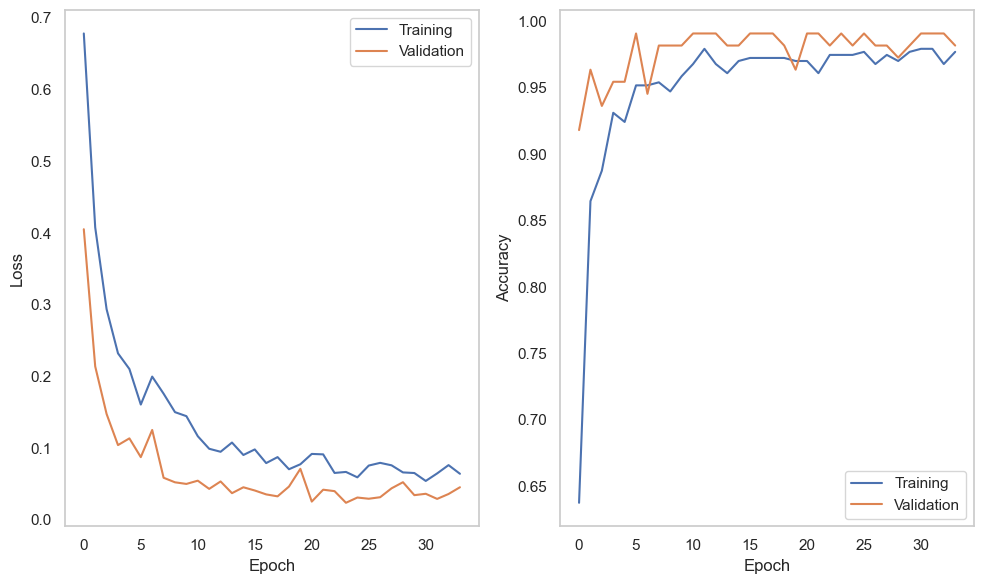

In [25]:
figure, axes = plt.subplots(1, 2)

axis=axes[0]
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
axis.plot(training_loss, label="Training")
axis.plot(validation_loss, label="Validation")
axis.grid()
axis.legend()
axis.set_xlabel("Epoch")
axis.set_ylabel("Loss")

axis = axes[1]
training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]
axis.plot(training_accuracy, label="Training")
axis.plot(validation_accuracy, label="Validation")
axis.grid()
axis.legend()
axis.set_xlabel("Epoch")
axis.set_ylabel("Accuracy")

figure.set_size_inches(10, 6)
figure.tight_layout()

plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        93
           1       0.89      0.93      0.91        44

    accuracy                           0.94       137
   macro avg       0.93      0.94      0.93       137
weighted avg       0.94      0.94      0.94       137



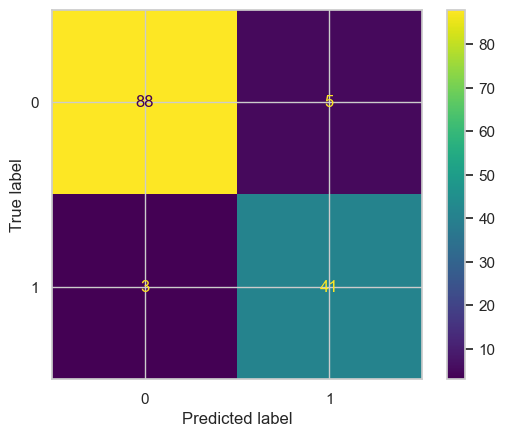

In [9]:
optimized_model = keras.saving.load_model("optimized_model.keras", custom_objects=None, compile=True, safe_mode=True)
y_pred_prob = optimized_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred))

In [11]:
# Calculate SHAP values for best model

explainer = shap.KernelExplainer(optimized_model.predict, x_train)
shap_values = explainer.shap_values(x_test, nsamples=100)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Using 546 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/137 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  1%|          | 1/137 [00:03<06:54,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  1%|▏         | 2/137 [00:06<06:55,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  2%|▏         | 3/137 [00:08<06:36,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


  3%|▎         | 4/137 [00:12<06:54,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


  4%|▎         | 5/137 [00:15<06:56,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


  4%|▍         | 6/137 [00:19<07:25,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


  5%|▌         | 7/137 [00:22<07:25,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  6%|▌         | 8/137 [00:25<06:52,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  7%|▋         | 9/137 [00:28<06:31,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  7%|▋         | 10/137 [00:30<06:02,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  8%|▊         | 11/137 [00:33<05:44,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  9%|▉         | 12/137 [00:35<05:30,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  9%|▉         | 13/137 [00:38<05:30,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 10%|█         | 14/137 [00:41<05:34,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 11%|█         | 15/137 [00:44<05:42,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 12%|█▏        | 16/137 [00:46<05:38,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 12%|█▏        | 17/137 [00:50<05:43,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 13%|█▎        | 18/137 [00:53<05:58,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 14%|█▍        | 19/137 [00:56<06:09,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 15%|█▍        | 20/137 [01:00<06:16,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 15%|█▌        | 21/137 [01:02<05:54,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 16%|█▌        | 22/137 [01:06<05:57,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 17%|█▋        | 23/137 [01:09<05:58,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 18%|█▊        | 24/137 [01:12<05:46,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 18%|█▊        | 25/137 [01:15<05:40,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 19%|█▉        | 26/137 [01:17<05:18,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 20%|█▉        | 27/137 [01:20<04:58,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step


 20%|██        | 28/137 [01:22<04:44,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 21%|██        | 29/137 [01:25<04:43,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 22%|██▏       | 30/137 [01:27<04:42,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 23%|██▎       | 31/137 [01:30<04:46,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 23%|██▎       | 32/137 [01:33<04:40,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 24%|██▍       | 33/137 [01:36<04:54,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 25%|██▍       | 34/137 [01:39<05:14,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 26%|██▌       | 35/137 [01:42<04:53,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 26%|██▋       | 36/137 [01:44<04:38,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 925us/step


 27%|██▋       | 37/137 [01:47<04:18,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 910us/step


 28%|██▊       | 38/137 [01:49<04:04,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step


 28%|██▊       | 39/137 [01:51<03:53,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 925us/step


 29%|██▉       | 40/137 [01:53<03:44,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step


 30%|██▉       | 41/137 [01:55<03:40,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 31%|███       | 42/137 [01:58<03:48,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 31%|███▏      | 43/137 [02:01<04:08,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 32%|███▏      | 44/137 [02:04<04:13,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 33%|███▎      | 45/137 [02:07<04:06,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 34%|███▎      | 46/137 [02:09<03:54,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 34%|███▍      | 47/137 [02:12<03:51,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 35%|███▌      | 48/137 [02:14<03:44,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 36%|███▌      | 49/137 [02:17<03:39,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step


 36%|███▋      | 50/137 [02:19<03:31,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 37%|███▋      | 51/137 [02:21<03:29,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step


 38%|███▊      | 52/137 [02:23<03:22,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 39%|███▊      | 53/137 [02:26<03:30,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step


 39%|███▉      | 54/137 [02:29<03:24,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step


 40%|████      | 55/137 [02:31<03:13,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 41%|████      | 56/137 [02:33<03:20,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 42%|████▏     | 57/137 [02:36<03:24,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 42%|████▏     | 58/137 [02:39<03:23,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 43%|████▎     | 59/137 [02:41<03:22,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 44%|████▍     | 60/137 [02:44<03:17,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 45%|████▍     | 61/137 [02:46<03:10,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 939us/step


 45%|████▌     | 62/137 [02:49<03:02,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 46%|████▌     | 63/137 [02:51<03:06,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 47%|████▋     | 64/137 [02:54<03:00,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 47%|████▋     | 65/137 [02:56<02:59,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 48%|████▊     | 66/137 [02:59<02:54,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step


 49%|████▉     | 67/137 [03:01<02:47,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 50%|████▉     | 68/137 [03:04<02:51,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step


 50%|█████     | 69/137 [03:06<02:48,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 51%|█████     | 70/137 [03:09<02:46,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 52%|█████▏    | 71/137 [03:11<02:45,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step


 53%|█████▎    | 72/137 [03:13<02:37,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step


 53%|█████▎    | 73/137 [03:15<02:27,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step


 54%|█████▍    | 74/137 [03:18<02:23,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 55%|█████▍    | 75/137 [03:20<02:28,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 55%|█████▌    | 76/137 [03:23<02:26,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step


 56%|█████▌    | 77/137 [03:25<02:21,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step


 57%|█████▋    | 78/137 [03:27<02:18,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 58%|█████▊    | 79/137 [03:30<02:17,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 58%|█████▊    | 80/137 [03:32<02:14,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step


 59%|█████▉    | 81/137 [03:34<02:09,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 60%|█████▉    | 82/137 [03:37<02:10,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step


 61%|██████    | 83/137 [03:39<02:08,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 61%|██████▏   | 84/137 [03:42<02:11,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 62%|██████▏   | 85/137 [03:44<02:11,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 63%|██████▎   | 86/137 [03:47<02:11,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 64%|██████▎   | 87/137 [03:51<02:23,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 64%|██████▍   | 88/137 [03:53<02:12,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step


 65%|██████▍   | 89/137 [03:55<02:01,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step


 66%|██████▌   | 90/137 [03:57<01:54,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 931us/step


 66%|██████▋   | 91/137 [04:00<01:48,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step


 67%|██████▋   | 92/137 [04:02<01:46,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 68%|██████▊   | 93/137 [04:05<01:52,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 69%|██████▊   | 94/137 [04:08<01:50,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 69%|██████▉   | 95/137 [04:11<01:56,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 70%|███████   | 96/137 [04:13<01:50,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 71%|███████   | 97/137 [04:16<01:47,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 72%|███████▏  | 98/137 [04:19<01:43,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step


 72%|███████▏  | 99/137 [04:21<01:35,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 73%|███████▎  | 100/137 [04:23<01:31,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 74%|███████▎  | 101/137 [04:26<01:29,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 74%|███████▍  | 102/137 [04:28<01:27,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 75%|███████▌  | 103/137 [04:31<01:24,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 76%|███████▌  | 104/137 [04:33<01:21,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 77%|███████▋  | 105/137 [04:35<01:19,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 77%|███████▋  | 106/137 [04:38<01:20,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 78%|███████▊  | 107/137 [04:41<01:21,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 79%|███████▉  | 108/137 [04:44<01:18,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 80%|███████▉  | 109/137 [04:47<01:17,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 80%|████████  | 110/137 [04:50<01:18,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 81%|████████  | 111/137 [04:53<01:15,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 82%|████████▏ | 112/137 [04:56<01:13,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 82%|████████▏ | 113/137 [04:59<01:09,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 83%|████████▎ | 114/137 [05:02<01:05,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 84%|████████▍ | 115/137 [05:04<01:02,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 85%|████████▍ | 116/137 [05:07<00:59,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 85%|████████▌ | 117/137 [05:10<00:55,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 86%|████████▌ | 118/137 [05:13<00:53,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 87%|████████▋ | 119/137 [05:15<00:49,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 88%|████████▊ | 120/137 [05:18<00:45,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 88%|████████▊ | 121/137 [05:20<00:41,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step


 89%|████████▉ | 122/137 [05:23<00:37,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 90%|████████▉ | 123/137 [05:25<00:34,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 91%|█████████ | 124/137 [05:28<00:32,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 91%|█████████ | 125/137 [05:30<00:30,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 92%|█████████▏| 126/137 [05:33<00:28,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 93%|█████████▎| 127/137 [05:35<00:25,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 93%|█████████▎| 128/137 [05:38<00:23,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 94%|█████████▍| 129/137 [05:41<00:20,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 95%|█████████▍| 130/137 [05:43<00:17,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step


 96%|█████████▌| 131/137 [05:45<00:14,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 96%|█████████▋| 132/137 [05:48<00:12,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 97%|█████████▋| 133/137 [05:50<00:10,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 98%|█████████▊| 134/137 [05:53<00:07,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 99%|█████████▊| 135/137 [05:55<00:04,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 99%|█████████▉| 136/137 [05:58<00:02,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


100%|██████████| 137/137 [06:00<00:00,  2.63s/it]


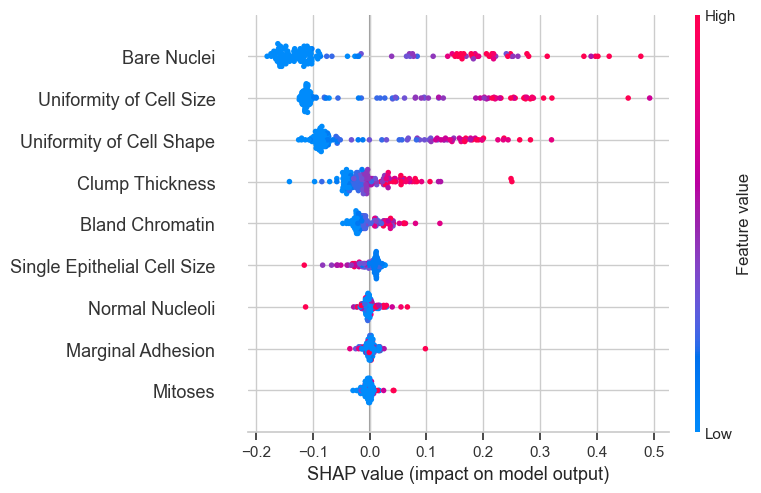

In [16]:
# Plot SHAP values for network
shap.summary_plot(shap_values[:, :, 0], x_test, feature_names=independent_variables)

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        93
           1       0.00      0.00      0.00        44

    accuracy                           0.68       137
   macro avg       0.34      0.50      0.40       137
weighted avg       0.46      0.68      0.55       137



/home/love/Programs/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/love/Programs/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/love/Programs/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

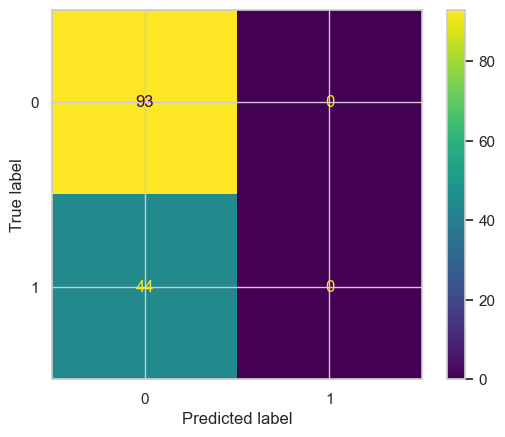

In [27]:
y_pred_majority_class = np.zeros(len(x_test))

cm = confusion_matrix(y_test, y_pred_majority_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred_majority_class))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94        93
           1       0.88      0.86      0.87        44

    accuracy                           0.92       137
   macro avg       0.91      0.90      0.91       137
weighted avg       0.92      0.92      0.92       137



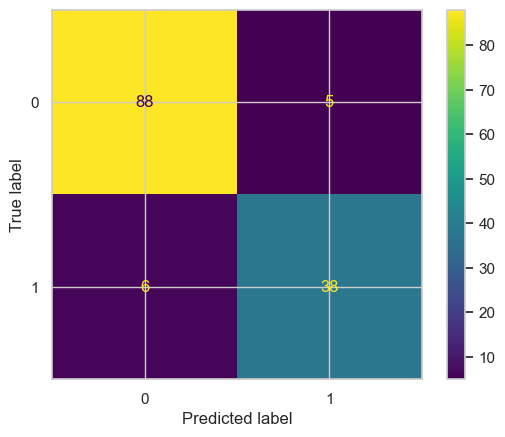

In [28]:
seed = 1245676453
logreg = sklearn.linear_model.LogisticRegression(random_state=seed)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred))

__(3)__ Include data analysis with one or more methods of statistical learning from the course

* Unsupervised Learning – Clustering
* Supervised Learning – Classification
* __Neural Network Implementation__
* __Predictive modelling__

__(4)__ Justify the choice and discussion of limitations of the method

__(5)__ Data visualisation and a discussion of why particular graph styles were chosen.

__(6)__ Reflection on FAIR principles, and how each concept of the acronym relates to the project (data and workflow).

* __F__ - Findable:

In order to make sure the data and workflow is findable it should be easy to fin both for humans and computers. Hence the workflow is opened at GitHub ([Follow Link to GitHub](https://github.com/18alle18/Reproducible-Challenge-Project)) with a README and the following keywords; $\textit{neural-network}$, $\textit{logistic-regression}$ and $\textit{breast-cancer-prediction}$.
* __A__ - Accessible:

Regarding accessibility, the notebook is uploaded under open access and open for preview and downloading for usage at Github. The data is also open to download as a CSV file. The README file explains how to use the notebook, explains the data, lists the license and links the original dataset.

* __I__ - Interoperable:
* __R__ - Reusable:

__(7)__ All of the above should be implemented in a reproducible workflow, e.g. a Jupyter Notebook. Please upload it to complete the final assignment.

__(8)__ Finally, all groups present their project for the class, maximum 10 minutes per group (please rehearse beforehand to ensure that you keep this limit, as the schedule is tight).

# Report

### Introduction and Objective

The purpose of this project was to classify breast cancer tumors as either benign or malignant based on the characteristics of epithelial cells collected from biopsies. We used data from the University of Wisconsin Hospitals, and the process of data collection was described by Wolberg and Mangasarian in 1990 (https://doi.org/10.1073/pnas.87.23.9193). Wolberg and Mangasarian used the multi-surface method for classifying benign and malignant tumor in different stages. The data can be downloaded from the UC Irvine Machine Learning Repository: https://doi.org/10.24432/C5HP4Z.

In our project, we wanted to compare logistic regression with a neural network, to determine if there were complex interactions in the data that could not be captured by logistic regression. We also wanted to determine which cell characteristics were most important for determining if tumors were benign or malignant.

In total, there were 9 independent variables:

- Clump thickness: How many layers cell clumps contained.
- Uniformity of Cell Size
- Uniformity of Cell Shape
- Marginal adhesion: How much the surrounding cells would adhere to the cell clump.
- Single Epithelial Cell size: Diameter of the largest epithelial cell population in relation to the diameter of erythrocytes.
- Bare nuclei: Proportion of epithelial cell nuclei without cytoplasm.
- Bland Chromatin: To what extent the chromatin was smooth, in contrast to clumped.
- Normal nucleli: To what extent nuclei appeared normal.
- Mitoses: Frequency of mitosis.

These variables were encoded as discrete variables between 1 and 10.

### Methodology for each task

### Results with supporting visuals

### Interpretation of Findings

### Conclusion summarizing key insights